In two previous posts, I explored the role of preprocessing data in the machine learning pipeline. In particular, I checked out the <a href = 'https://www.datacamp.com/community/tutorials/the-importance-of-preprocessing-in-data-science-and-the-machine-learning-pipeline-i-centering-scaling-and-k-nearest-neighbours'>k-Nearest Neighbors (k-NN)</a> and <a href = 'https://www.datacamp.com/community/tutorials/the-importance-of-preprocessing-in-data-science-and-the-machine-learning-pipeline-ii-centering-scaling-and-logistic-regression'> logistic regression</a> algorithms and saw how scaling numerical data strongly influenced the performance of the former but not that of the latter, as measured, for example, by accuracy (see Glossary below or previous articles for definitions of scaling, k-NN and other relevant terms). The real take home message here was that preprocessing doesn't occur in a vacuum, that is, you can prepocess the heck out of your data but the proof is in the pudding: how well does your model then perform?

Scaling numerical data (that is, multiplying all instances of a variable by a constant in order to change that variable's range) has two related purposes: i) if your measurements are in meters and mine are in miles, then, if we both scale our data, they end up being the same & ii) if two variables have vastly different ranges, the one with the larger range may dominate your predictive model, even though it may be less important to your target variable than the variable with the smaller range. What we saw is that this problem identified in ii) occurs with k-NN, which explicitly looks at how close data are to one another but not in logistic regression which, when being trained, will shrink the relevant coefficient to account for the lack of scaling.

As the data we used in the previous articles was real-world data, all we could see was how the models performed before and after scaling. Here, in order to see how noise in the form of nuisance variables (those which do not effect the target variable but may effect your model) changes model performance both pre- and post-scaling, I'll synthesize a dataset in which I can control the precise nature of the nuisance variable. **We'll see that the noisier the sythesized data, the more important scaling will be for k-NN**. All examples herein will be in Python. If you're not familiar with Python, you can check out our DataCamp courses <a href = 'https://www.datacamp.com/'>here</a>. I will make use of the libraries <a href = 'http://pandas.pydata.org/'>pandas</a> for our dataframe needs and <a href = 'http://scikit-learn.org/stable/'>scikit-learn</a> for our machine learning needs.

In the code chunk below, we use scikit-learn's *make_blobs function* to generate 2000 data points that are in 4 clusters (each data point has 2 predictor variables and 1 target variable).

In [1]:
# Generate some clustered data (blobs!)
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
n_samples=2000
X, y = make_blobs(n_samples, centers=4, n_features=2,
                  random_state=0)

#### Plotting the synthesized data


We'll now plot in the plane the data that we've synthesized. Each axis is a predictor variable and the colour is a key to the target variable:

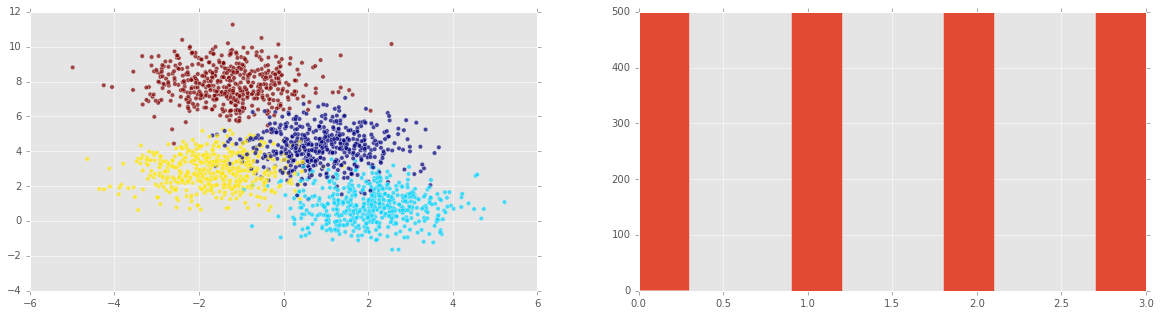

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.scatter(X[:,0] , X[:,1],  c = y, alpha = 0.7);
plt.subplot(1, 2, 2);
plt.hist(y)
plt.show()

*Note: we can see in the 2nd plot that all possible target variables are equally represented. In this case (or even if they are approximately equally represented), we say that the class y is balanced.*

I now want to plot histograms of the features (predictor variables):

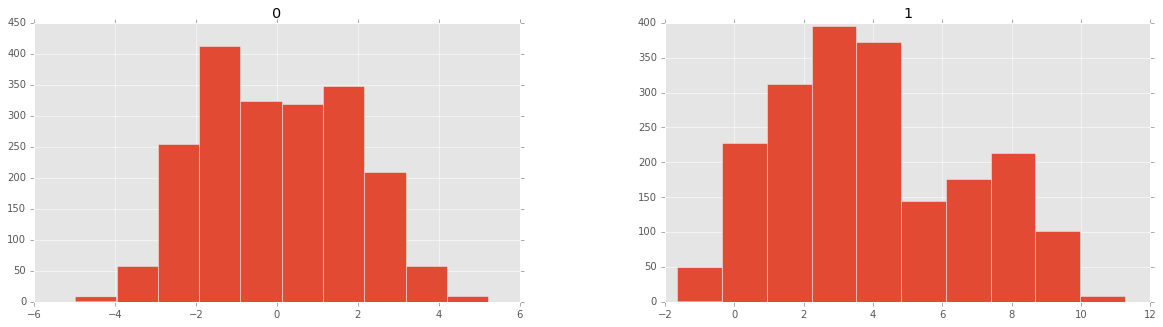

In [3]:
import pandas as pd
df = pd.DataFrame(X)
pd.DataFrame.hist(df, figsize=(20,5));

Let's now split into testing & training sets & plot both sets:

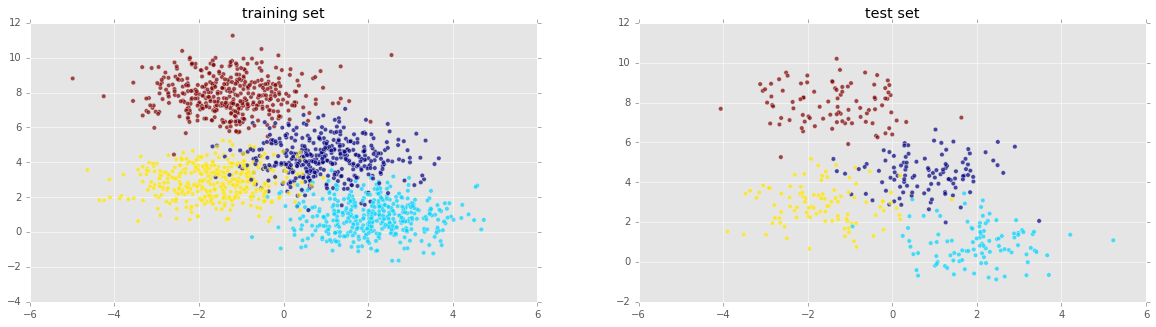

In [4]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.title('training set')
plt.scatter(X_train[:,0] , X_train[:,1],  c = y_train, alpha = 0.7);
plt.subplot(1, 2, 2);
plt.scatter(X_test[:,0] , X_test[:,1],  c = y_test, alpha = 0.7);
plt.title('test set')
plt.show()

Looking good! Now let's instantiate a k-Nearest Neighbors voting classifier and train it on our training set:

In [5]:
from sklearn import neighbors, linear_model
knn = neighbors.KNeighborsClassifier()
knn_model = knn.fit(X_train, y_train)

Now that we have trained our model we can fit it to our test set and compute the accuracy:

In [6]:
print('k-NN score for test set: %f' % knn_model.score(X_test, y_test))

k-NN score for test set: 0.935000


We can also re-fit it to our training set and compute the accuracy. We would expect it to perform better on the training set than the test set:

In [7]:
print('k-NN score for training set: %f' % knn_model.score(X_train, y_train))

k-NN score for training set: 0.941875


It is worth reiterating that the default scoring method for k-NN in scikit-learn is *accuracy*. To check out a variety of other metrics, we can use scikit-learn's classification report also: 

In [8]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test, knn_model.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.87      0.90      0.88       106
          1       0.98      0.93      0.95       102
          2       0.90      0.92      0.91       100
          3       1.00      1.00      1.00        92

avg / total       0.94      0.94      0.94       400



#### Now with scaling

I'll now scale the predictor variables and then use k-NN again:

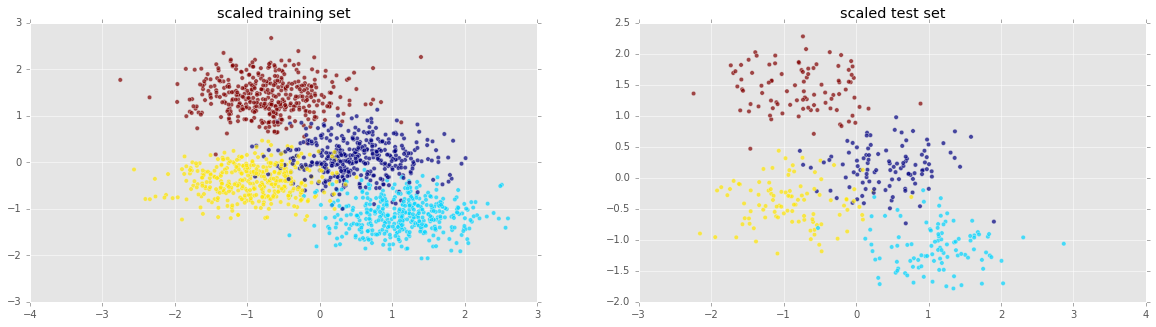

In [9]:
from sklearn.preprocessing import scale
Xs = scale(X)
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.scatter(Xs_train[:,0] , Xs_train[:,1],  c = y_train, alpha = 0.7);
plt.title('scaled training set')
plt.subplot(1, 2, 2);
plt.scatter(Xs_test[:,0] , Xs_test[:,1],  c = y_test, alpha = 0.7);
plt.title('scaled test set')
plt.show()

In [10]:
knn_model_s = knn.fit(Xs_train, y_train)
print('k-NN score for test set: %f' % knn_model_s.score(Xs_test, y_test))

k-NN score for test set: 0.935000


It doesn't perform any better with scaling! This is most likely because both features were already around the same range. It really makes sense to scale when variables have widely varying ranges. To see this in action, we're going to add another feature. Moreover, this feature will bear no relevance to the target variable: it will be mere noise.

#### Adding noise to the signal:

We add a third variable of Gaussian noise with mean 0 and variable standard deviation $\sigma$. We'll call $\sigma$ the strength of the noise and we'll see that the stronger the noise, the worse the performance of k-Nearest Neighbours.

In [11]:
# Add noise column to predictor variables
ns = 10**(3) # Strength of noise term
newcol = np.transpose([ns*np.random.randn(n_samples)])
Xn = np.concatenate((X, newcol), axis = 1)

We'll now use the mplot3d package to plot the 3D data:

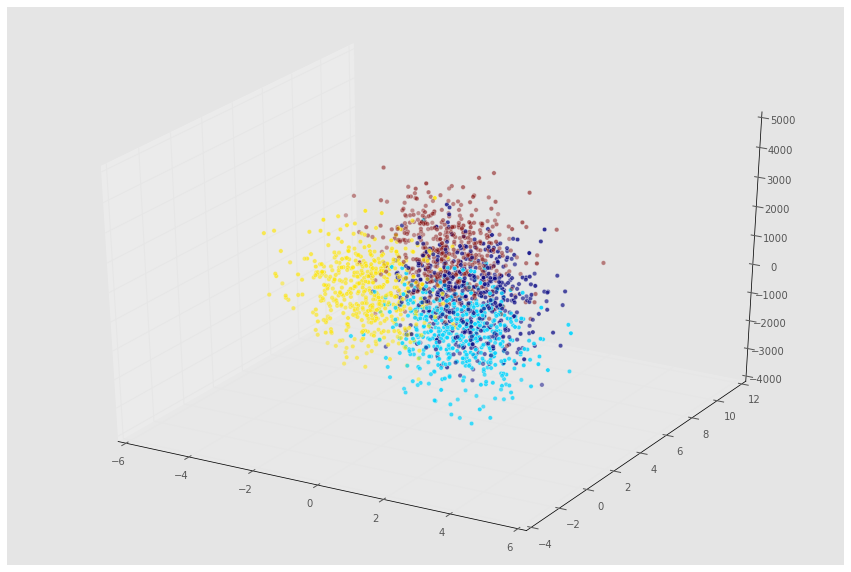

In [12]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,10));
ax = fig.add_subplot(111, projection='3d' , alpha = 0.5);
ax.scatter(Xn[:,0], Xn[:,1], Xn[:,2], c = y);

Now let's see how our model performs on the new data:

In [13]:
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size=0.2, random_state=42)
knn = neighbors.KNeighborsClassifier()
knn_model = knn.fit(Xn_train, y_train)
print('k-NN score for test set: %f' % knn_model.score(Xn_test, y_test))

k-NN score for test set: 0.400000


This is a horrible model! How about we scale and check out performance?

In [14]:
Xns = scale(Xn)
s = int(.2*n_samples)
Xns_train = Xns[s:]
y_train = y[s:]
Xns_test = Xns[:s]
y_test = y[:s]
knn = neighbors.KNeighborsClassifier()
knn_models = knn.fit(Xns_train, y_train)
print('k-NN score for test set: %f' % knn_models.score(Xns_test, y_test))

k-NN score for test set: 0.907500


Great, so after scaling the data, the model performs nearly as well as were there no noise introduced. Let's now check out the model performance as a function of noise strength.

#### The stronger the noise, the bigger the problem:

We're now going to see how the noise strength effects model accuracy. As we'll need to use the same code a number of times, let's actually wrap up the main parts in a small function:

In [15]:
def accu( X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    knn = neighbors.KNeighborsClassifier()
    knn_model = knn.fit(X_train, y_train)
    return(knn_model.score(X_test, y_test))

In [16]:
noise = [10**i for i in np.arange(-1,6)]
A1 = np.zeros(len(noise))
A2 = np.zeros(len(noise))
count = 0
for ns in noise:
    newcol = np.transpose([ns*np.random.randn(n_samples)])
    Xn = np.concatenate((X, newcol), axis = 1)
    Xns = scale(Xn)
    A1[count] = accu( Xn, y)
    A2[count] = accu( Xns, y)
    count += 1

We now plot accuracy as a function of noise strength (note log x axis):

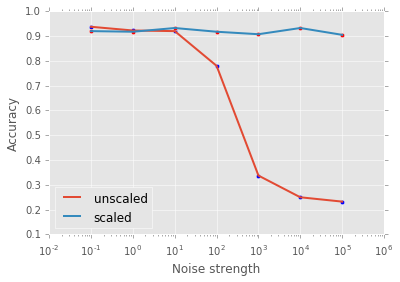

In [18]:
plt.scatter( noise, A1 )
plt.plot( noise, A1, label = 'unscaled', linewidth = 2)
plt.scatter( noise, A2 , c = 'r')
plt.plot( noise, A2 , label = 'scaled', linewidth = 2)
plt.xscale('log')
plt.xlabel('Noise strength')
plt.ylabel('Accuracy')
plt.legend(loc=3);

See in the above figure that the more noise there is in the nuisance variable, the more important it is to scale your data for the k-NN model! Below, you'll have the opportunity to do the same for logistic regression. To conclude, we have seen the essential place occupied in the data scientific pipeline by preprocessing, in its scaling and centering incarnation, and we have done so to promote a holistic approach to the challenges of machine learning. In future articles, I hope to extend this discussion to other types of preprocessing, such as transformations of numerical data and preprocessing of categorical data, both essential aspects of any data scientists's toolkit.

**Exercise for the avid reader:** try out fitting a logistic regression model to the above synthesized datasets and check out the model performance. How is accuracy a function of noise strength for scaled and unscaled data, respectively? You can do so in the DataCamp Light widget below! Change the exponent of 10 to alter the amount of noise (first try the range that I tried above for k-NN) and set *sc = True* if you want to scale your features. You can also check out <a href = 'https://github.com/datacamp/datacamp-light'> DataCamp Light on Github</a>!

___
### Glossary

**Supervised learning:** The task of inferring a *target variable* from *predictor variables*. For example, inferring the *target variable* 'presence of heart disease' from *predictor variables* such as 'age', 'sex', and 'smoker status'.


**Classification task:** A *supervised learning* task is a *classification task* if the target variable consists of categories (e.g. 'click' or 'not', 'malignant' or 'benign' tumour).

**Regression task:** A *supervised learning* task is a *regression task* if the target variable is a continuously varying variable (e.g. price of a house) or an ordered categorical variable such as 'quality rating of wine'.

**k-Nearest Neighbors:** An algorithm for *classification tasks*, in which a data point is assigned the label decided by a majority vote of its k nearest neighbors.

**Preprocessing:** Any number of operations data scientists will use to get their data into a form more appropriate for what they want to do with it. For example, before performing sentiment analysis of twitter data, you may want to strip out any html tags, white spaces, expand abbreviations and split the tweets into lists of the words they contain.

**Centering and Scaling:** These are both forms of preprocessing *numerical data*, that is, data consisting of numbers, as opposed to categories or strings, for example; *centering* a variable is subtracting the mean of the variable from each data point so that the new variable's mean is 0; *scaling* a variable is multiplying each data point by a constant in order to alter the range of the data. See the body of the article for the importance of these, along with examples.


*This article was generated from a Jupyter notebook. You can download the notebook <a href = 'https://github.com/hugobowne/machine_learning_techniques/blob/master/notes_on_ML/Scaling_synthesized_data.ipynb'>here</a>.*